In [ ]:
!pip install Sastrawi emoji openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import re
import emoji
from nltk.tokenize import wordpunct_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files


In [47]:
data = pd.read_excel("Raw_BhumiMerapi.xlsx")

# === Baca file stopword ===
with open("stopwords-id.txt", "r", encoding="utf-8") as f:
    stop_words = set(f.read().splitlines())

stop_words.update([
    'aja','ya','deh','dong','sih','nih','loh','lho','toh',
    'pa','ha','kan','dll','dg','org','yg','karna','kalo',
    'nggak','ga','gak','udah','udh','nya','nyaa','krn''jadi', 'dari', 'oke', 'dengan', 'karena'
])

print(f"Jumlah stopword dimuat: {len(stop_words)} kata")

# Tampilkan beberapa baris pertama
data.head()

Jumlah stopword dimuat: 782 kata


,review
0,Harganya naik menjadi 40k krn liburan. Anak2 b...
1,Tempat wisata keluarga yang cocok juga untuk e...
2,Tempat ini bagus untuk berlibur bersama keluar...
3,Tempat ini lebih ke mini zoo ya sama spot foto...
4,Tempat mudah ditemukan karena petunjuk jalan y...


In [48]:
normalisasi_dict = {
    # singkatan umum
    'gak': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak',
    'yg': 'yang', 'aja': 'saja', 'tp': 'tapi', 'sm': 'sama', 'dr': 'dari',
    'sy': 'saya', 'kmu': 'kamu', 'dgn': 'dengan', 'dg': 'dengan', 'trs': 'terus',
    'udh': 'sudah', 'udah': 'sudah', 'utk': 'untuk', 'bkn': 'bukan',
    'krn': 'karena', 'karna': 'karena', 'pdhl': 'padahal', 'klo': 'kalau',
    'kl': 'kalau', 'dl': 'dulu', 'skrg': 'sekarang', 'sdh': 'sudah',
    'trnyata': 'ternyata', 'hrs': 'harus', 'jd': 'jadi', 'jg': 'juga',
    'org': 'orang', 'orgnya': 'orangnya', 'dll': '', 'pa': 'pak', 'ha': '',

    # kata gaul
    'bgt': 'banget', 'bngt': 'banget', 'btw': 'ngomong-ngomong',
    'mager': 'malas gerak', 'anjir': '', 'anjay': '', 'wkwk': '', 'wkwwk': '',
    'haha': '', 'hehe': '', 'lol': '', 'ngab': '', 'mantappp': 'mantap',

    # typo dan variasi
    'baguus': 'bagus', 'terbaikkk': 'terbaik', 'bgttt': 'banget',
    'mkn': 'makan', 'mknnya': 'makanannya', 'mankap': 'mantap'
}


In [49]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()


In [52]:
def remove_emoji(text):
    return emoji.replace_emoji(str(text), replace='')

def preprocess_text_steps(text, hapus_angka=True):
    steps = {}
    text = str(text).lower()

    # 1️⃣ Case folding
    steps['case_folding'] = text

    # 2️⃣ Hapus emoji
    text = remove_emoji(text)
    steps['remove_emoji'] = text

    # 3️⃣ Hapus frasa khusus (misal nama tempat)
    text = re.sub(r'\bbhumi\s+merapi\b', '', text)
    steps['remove_phrase'] = text

    # 4️⃣ Hapus huruf berulang
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    steps['remove_repeated_char'] = text

    # 5️⃣ Hapus akhiran -nya dan kata 'nya' terpisah
    text = re.sub(r'\b(\w+)nya\b', r'\1', text)
    text = re.sub(r'\bnya\b', '', text)
    steps['remove_suffix_nya'] = text

    # 6️⃣ Hapus angka dan satuannya (30k, 15rb, 2jam, dst.)
    if hapus_angka:
        text = re.sub(r'\b\d+\s?(k|rb|jt|jam|menit|x)?\b', '', text)
    steps['remove_numbers'] = text

    # 7️⃣ Hapus simbol / karakter non-huruf
    text = re.sub(r'[^a-z\s]', ' ', text)
    steps['remove_nonalpha'] = text

    # 8️⃣ Tokenisasi
    tokens = wordpunct_tokenize(text)
    steps['tokenization'] = tokens

    # 9️⃣ Normalisasi (singkatan + kata gaul)
    tokens = [normalisasi_dict[w] if w in normalisasi_dict else w for w in tokens]
    tokens = [w for w in tokens if w != '']
    steps['normalization'] = tokens

    # 🔟 Stopword Removal (setelah normalisasi)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    steps['stopword_removal'] = tokens

    # 1️⃣1️⃣ Stemming
    tokens = [stemmer.stem(w) for w in tokens]
    steps['stemming'] = tokens

    # 1️⃣2️⃣ Gabungkan kembali
    cleaned_text = ' '.join(tokens)
    steps['final_text'] = cleaned_text.strip()

    return steps


In [53]:
sample = data['review'][0]
print("🔹 TEKS ASLI:\n", sample, "\n")

result = preprocess_text_steps(sample)
for step, output in result.items():
    print(f"🔸 {step.upper()}:\n{output}\n")


🔹 TEKS ASLI:
 Harganya naik menjadi 40k krn liburan. Anak2 bisa foto bersama hewan yg ada disana. Spot fotonya juga bagus2. Tapi Harga jajanan nya mahal. 

🔸 CASE_FOLDING:
harganya naik menjadi 40k krn liburan. anak2 bisa foto bersama hewan yg ada disana. spot fotonya juga bagus2. tapi harga jajanan nya mahal.

🔸 REMOVE_EMOJI:
harganya naik menjadi 40k krn liburan. anak2 bisa foto bersama hewan yg ada disana. spot fotonya juga bagus2. tapi harga jajanan nya mahal.

🔸 REMOVE_PHRASE:
harganya naik menjadi 40k krn liburan. anak2 bisa foto bersama hewan yg ada disana. spot fotonya juga bagus2. tapi harga jajanan nya mahal.

🔸 REMOVE_REPEATED_CHAR:
harganya naik menjadi 40k krn liburan. anak2 bisa foto bersama hewan yg ada disana. spot fotonya juga bagus2. tapi harga jajanan nya mahal.

🔸 REMOVE_SUFFIX_NYA:
harga naik menjadi 40k krn liburan. anak2 bisa foto bersama hewan yg ada disana. spot foto juga bagus2. tapi harga jajanan  mahal.

🔸 REMOVE_NUMBERS:
harga naik menjadi  krn liburan. ana

In [54]:
def preprocess_final(text):
    return preprocess_text_steps(text)['final_text']

data['cleaned_review'] = data['review'].apply(preprocess_final)


In [55]:
comparison = data[['review', 'cleaned_review']]
comparison.head(20)


,review,cleaned_review
0,Harganya naik menjadi 40k krn liburan. Anak2 b...,harga libur anak foto hewan sana spot foto bag...
1,Tempat wisata keluarga yang cocok juga untuk e...,wisata keluarga cocok edukasi anak anak sedia ...
2,Tempat ini bagus untuk berlibur bersama keluar...,bagus libur keluarga milik anak temoatbini meg...
3,Tempat ini lebih ke mini zoo ya sama spot foto...,mini zoo spot foto lumayan anak kuda kasih mak...
4,Tempat mudah ditemukan karena petunjuk jalan y...,mudah temu tunjuk jalan harga tiket mei rp par...
5,"bagus, apik, luas daerah wisatanya, kmdian ban...",bagus apik luas daerah wisata kmdian binatang ...
6,Bocil2 kesini suka banget dan betah. Banyak wa...,bocil kesini suka banget betah wahana main tam...
7,"Lokasi di Jogja utara, jalan kaliurang daerah ...",lokasi jogja utara jalan kaliurang daerah pake...
8,"Tempatnya luas, tiketnya lumayan worth it, ban...",luas tiket lumayan worth it bagus foto binatan...
9,"Suka banget dengan tempat ini, kebetulan kemar...",suka banget kemarin pas din cuaca mendung


In [61]:
output_path = "WisataBhumiMerapi_preprocessing_final.xlsx"
comparison.to_excel(output_path, index=False)
print(f"✅ File hasil preprocessing disimpan sebagai: {output_path}")


✅ File hasil preprocessing disimpan sebagai: WisataBhumiMerapi_preprocessing_final.xlsx


In [57]:
!pip install wordcloud matplotlib nltk


In [58]:
import pandas as pd
import nltk
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud


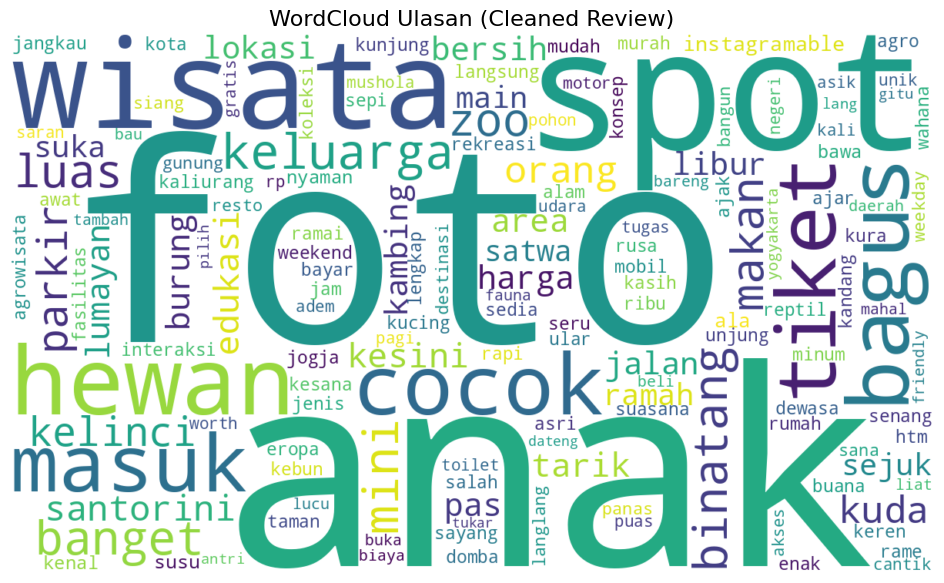

In [59]:
# Gabungkan semua teks
all_text = ' '.join(data['cleaned_review'].astype(str))

# Buat WordCloud
wc = WordCloud(width=1200, height=700,
               background_color='white',
               collocations=False,
               max_words=150,
               colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Ulasan (Cleaned Review)", fontsize=16)
plt.show()


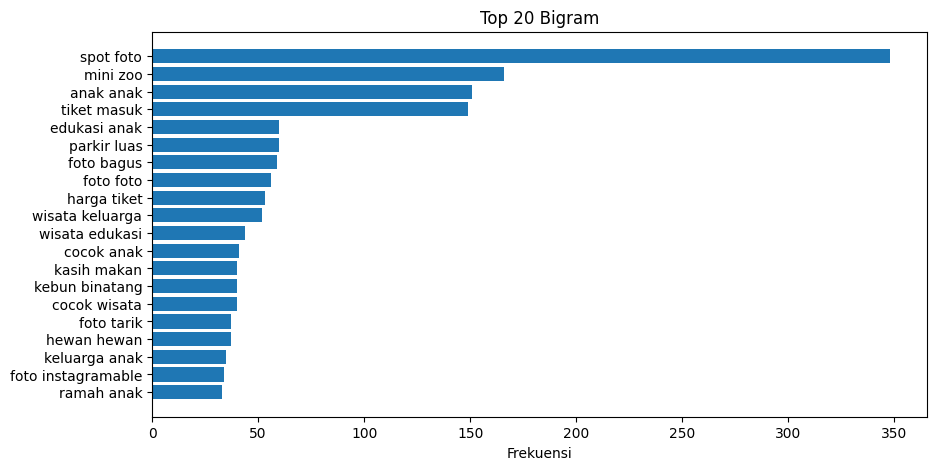

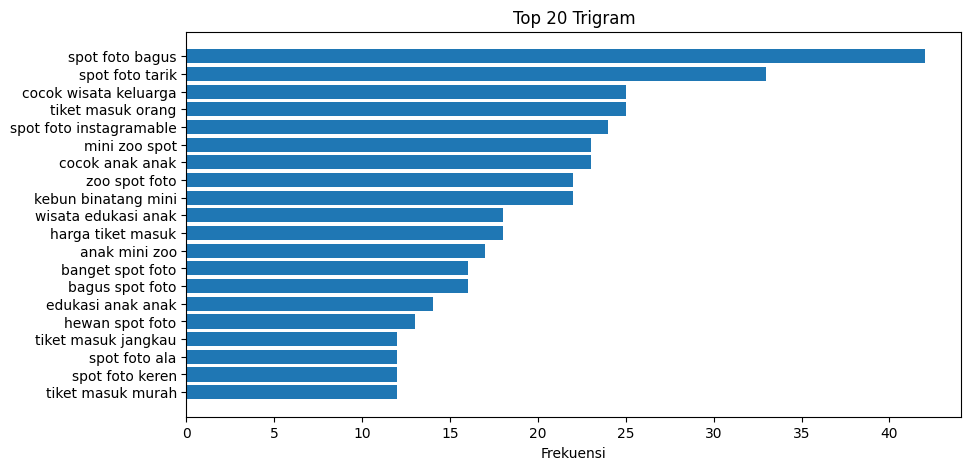

In [60]:
from nltk import ngrams
from collections import Counter

# Tokenisasi ulang untuk n-gram
tokens = all_text.split()

# Bigram
bigrams = list(ngrams(tokens, 2))
bigram_counts = Counter(bigrams).most_common(20)

plt.figure(figsize=(10,5))
plt.barh([' '.join(bg) for bg, _ in bigram_counts],
         [count for _, count in bigram_counts])
plt.gca().invert_yaxis()
plt.title("Top 20 Bigram")
plt.xlabel("Frekuensi")
plt.show()

# Trigram
trigrams = list(ngrams(tokens, 3))
trigram_counts = Counter(trigrams).most_common(20)

plt.figure(figsize=(10,5))
plt.barh([' '.join(tg) for tg, _ in trigram_counts],
         [count for _, count in trigram_counts])
plt.gca().invert_yaxis()
plt.title("Top 20 Trigram")
plt.xlabel("Frekuensi")
plt.show()
